In [61]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import cv2
import os
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

from skimage.feature import hog
from skimage import exposure

from pathlib import Path

from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import * 

from lime import lime_image

# Gotta Catch 'Em ALL
    As a kid growing up in 90s, I wondered about catching Pokémon, battling in gyms and using that cool Pokédex to
    get the info all I need. Here I wanted to apply my Machine Learning knowledge to build Pokedex and learn about Deep Learning skills. I used H.O.G and SVC to classify Pokémon and also CNN to classify them. 

# Preprocessing Data

In [ ]:
def collecting_image(dirs):
    """
        dirs - directories in a certain path folder.
        Takes png files in each directory and returns to a rgb matrix.
        If a png file is none, remove the png file.
        os.remove() will clean all broken png files.
    """
    image_data = []
    labels = []
    for folder in sorted(dirs):
        label = str(folder).split('/')[-1]
        count = 0
        count1 = 0 
        # Taking all png files in img_path (a pokemon folder)
        for img_path in folder.glob("*.png"):
            img_path = str(img_path)
            img = cv2.imread(img_path) 
            if img is not None:
                img = cv2.resize(img,(64,64)) # Resize an image to 64 pixels by 64 pixels
                img_array = image.img_to_array(img) # Convert an image to an array
                image_data.append(img_array)
                labels.append(label)
                count += 1
            else:
                print(img_path)
                os.remove(img_path)
                print("File Removed")
                count1 += 1
    print('# of Images: {} for {}'.format(count, label)) 
    print("# of Removed Images", count1)
    
    return(image_data, labels)


In [ ]:
# p = Path("./data/pokemon/")
# dirs = p.glob("*")
# image_data, labels = collecting_image(dirs)

# Saving Pokemon Label Dictionary to pickle


In [119]:
# labels_dict = {key: val for key, val in enumerate(sorted(set(labels)), 0)}
# pickle.dump(labels_dict, open('data/pokemon_label.p', 'wb'))
# pickle.dump(image_data, open('data/image_data.p', 'wb'))
# pickle.dump(labels, open('data/labels.p', 'wb'))

## Loading Pickles

In [37]:
labels_dict = pickle.load(open("data/pokemon_label.p", 'rb'))
image_data = pickle.load(open('data/image_data.p','rb'))
labels = pickle.load(open('data/labels.p','rb'))

In [38]:
X = np.array(image_data)
y = np.array(labels)
print(X.shape)
print(y.shape)

(42022, 64, 64, 3)
(42022,)


# EDA

In [47]:
from collections import Counter

pokemons, counts = zip(*Counter(y).items())
df_images = pd.DataFrame(index=pokemons, data={'# of Images':counts}) # Data Frame of the data
df_images.sort_index(inplace=True)


In [48]:
avg_num_images = df_images['# of Images'].mean()
median_num_images = df_images['# of Images'].median()

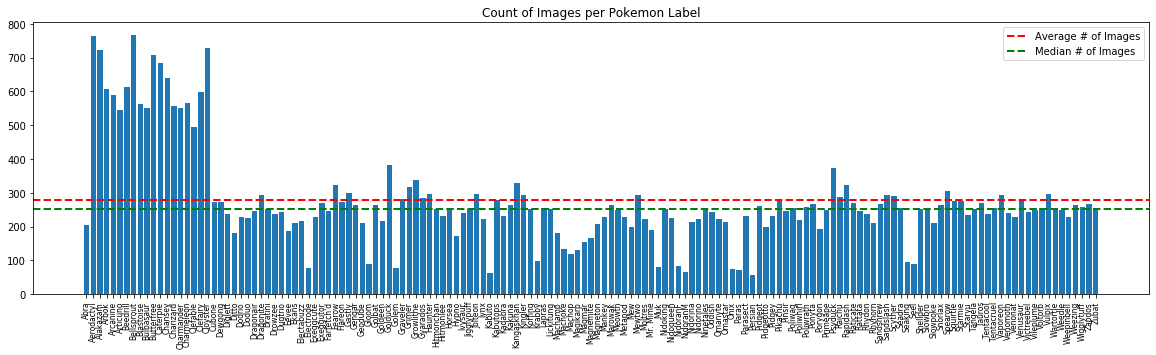

In [13]:
plt.figure(figsize=(20,5))
plt.bar(range(len(df_images)), df_images['# of Images'].values)
plt.axhline(avg_num_images, color='r', linestyle='dashed', linewidth=2, label='Average # of Images')
plt.axhline(median_num_images, color='g', linestyle='dashed', linewidth=2, label='Median # of Images')

plt.xticks(range(len(df_images)), df_images.index.values, size=7.5,rotation='vertical')
plt.legend()
plt.title('Count of Images per Pokemon Label')
# plt.savefig('distribution_images.png')
plt.show()


In [49]:
def get_last_10(df_images,n):
    """ Returns to a Dataframe, which represents 'n' lowest number of images
    """
    return (df_images.sort_values(by=['# of Images'])[0:n])

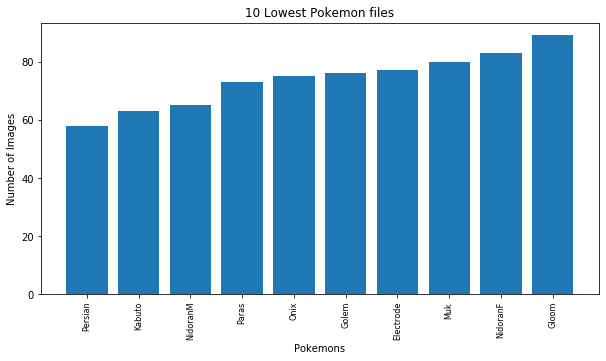

In [55]:
plt.figure(figsize=(10,5))
plt.bar(x=range(10), height=get_last_10(df_images,10)['# of Images'].values)
plt.xticks(range(10), get_last_10(df_images,10).index.values, rotation=90, fontsize=8)
plt.xlabel('Pokemons')
plt.ylabel('Number of Images')
plt.title('10 Lowest Pokemon files')
#plt.savefig('10_smallest_distributions.png')

## Normalizing Data

In [39]:
def pokemon_to_keys(y,labels_dict):
    """ y - list of pokemons
        labels_dict - {(0,151):'pokemon'}
        returns to corresponding key.
        
    """
    new_y = []
    for y_element in y:
        for k, v in labels_dict.items():
            if y_element == v:
                new_y.append(k)
    return(np.array(new_y))

In [40]:
# 'float32' type data is more efficiently trained in a neural network. Also can be normalized.
X = X.astype('float32') / 255.0

# Converting Pokemon labels to corresponding keys
y = pokemon_to_keys(y, labels_dict)

In [41]:
def drawImg(img,label):
    """ 
        Draw an input image with a label
    """
    
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

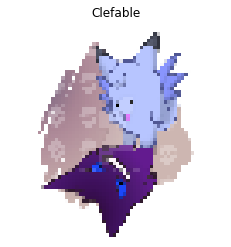

In [42]:
some_number = random.randint(a=0, b=len(X))
drawImg(X[some_number],labels_dict[y[some_number]])

## Generate Some Random Pokemons

In [8]:
def random_pokemon_key(key, array):
    return int(random.choice(np.argwhere(array == key)))

In [17]:
def display_sample_pokemons(samples_indices, img_array, labels, pred_labels=None, pred_probs=None):
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]

            ax[row,col].imshow(img_array[index])
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            if (pred_labels != None and pred != None):
                pred_label = labels_dict[pred_labels[index]]
                pred_prob = max(pred_probs[index])*100
                pred_text = "{} : {:.0f}%".format(pred_label,pred_prob)
                ax[row,col].text(1, 59, pred_text , horizontalalignment='left', fontproperties=font,
                                 verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

In [10]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y) for key in rand_pokemon_keys]

# Feature Extraction
## Histogram of Oriented Gradients


In [11]:
def display_hog_sample_pokemons(samples_indices, img_array, labels):
    n = 0
    nrows = 4
    ncols = 5
    assert (len(samples_indices) == nrows * ncols)
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]
            gray = cv2.cvtColor(img_array[index], cv2.COLOR_BGR2GRAY)
            # Compute the gradient vector or edge orientations at each pixel
            fd, hog_img = hog(gray, orientations=9, pixels_per_cell=(2, 2),
                    cells_per_block=(2, 2), visualize=True, block_norm='L1')
            
            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10))
            
            ax[row,col].imshow(hog_image_rescaled)
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,59, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

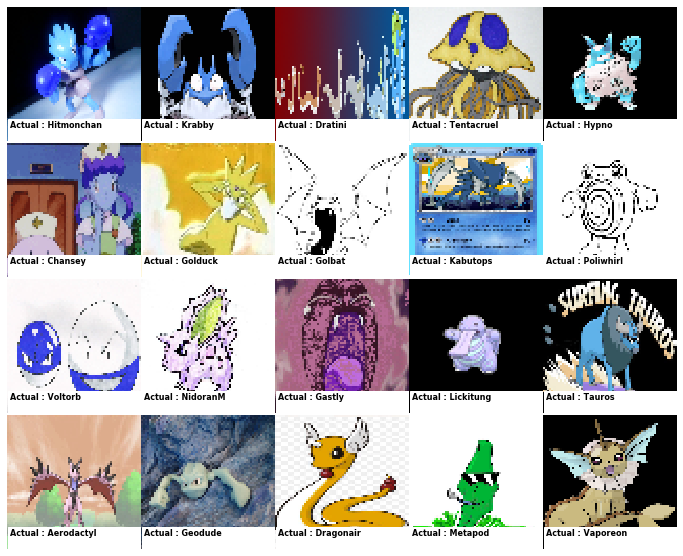

In [19]:
display_sample_pokemons(samples_indices, X, y)
# plt.savefig('sample_pokemons.png')

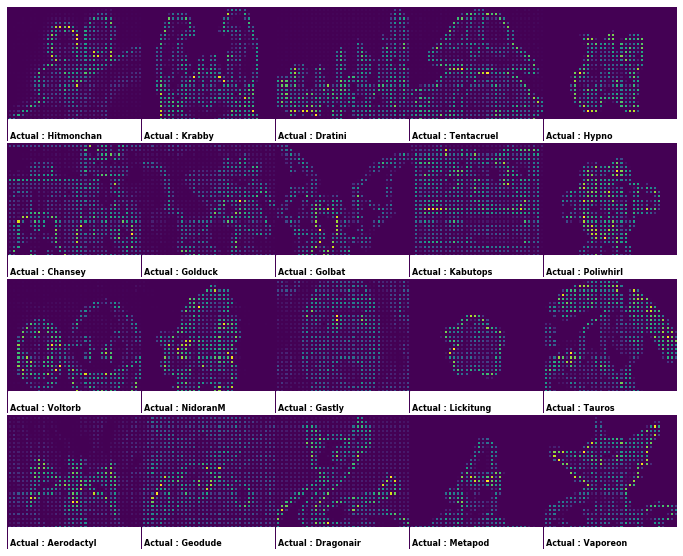

In [20]:
display_hog_sample_pokemons(samples_indices, X, y)
# plt.savefig('hog_sample_pokemons.png')

## Examples of Pokemons

In [21]:
squirtle_keys = np.empty(20)
squirtle_keys.fill(129)
squirtle = [random_pokemon_key(key, y) for key in squirtle_keys]

In [22]:
pikachu_keys = np.empty(20)
pikachu_keys.fill(103)
pikachu = [random_pokemon_key(key, y) for key in pikachu_keys]

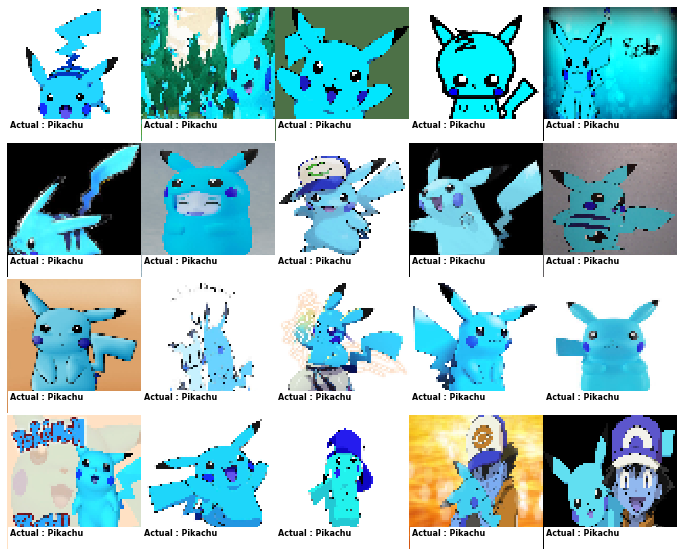

In [25]:
display_sample_pokemons(pikachu, X, y)
# plt.savefig('pikachu.png')

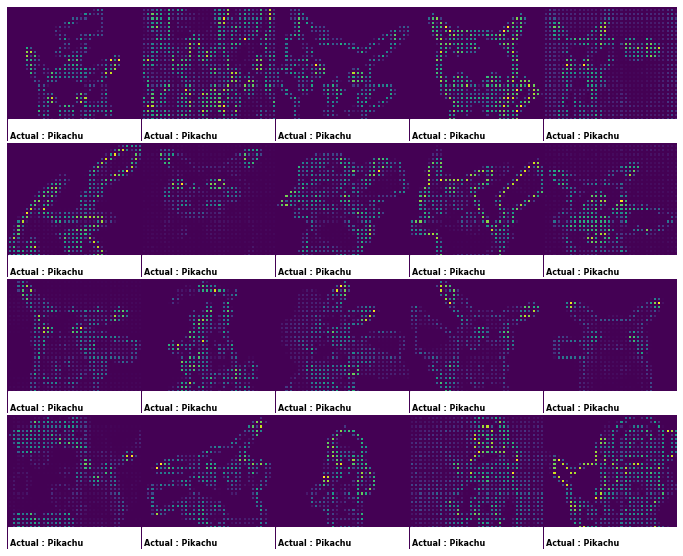

In [26]:
display_hog_sample_pokemons(pikachu, X, y)
# plt.savefig('hog_pikachu.png')

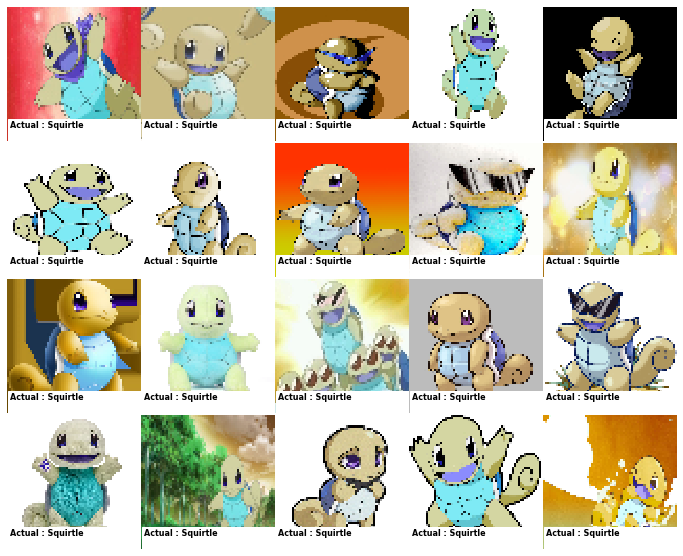

In [27]:
display_sample_pokemons(squirtle, X, y)
# plt.savefig('squirtle.png')

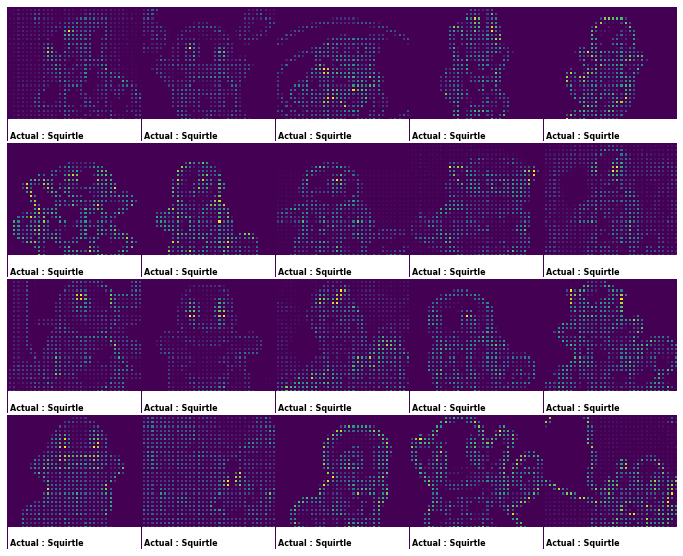

In [28]:
display_hog_sample_pokemons(squirtle, X, y)
# plt.savefig('hog_squirtle.png')

# Support Vector Classifier

In [24]:
# The normalization performed by scikit-image is not the one recommended by the paper. 
def extract_hog(img_array):
    """
        Extract Histogram of Oriented Gradients feature descriptions for an image.
        
    """
    winSize = (64,64)
    blockSize = (4,4)
    blockStride = (4,4)
    cellSize = (2,2)
    nbins = 9
    derivAperture = 1
    winSigma = -1
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True
    
    hogD = cv2.HOGDescriptor(winSize,
                            blockSize,
                            blockStride,
                            cellSize,
                            nbins,
                            derivAperture,
                            winSigma,
                            histogramNormType,
                            L2HysThreshold,
                            gammaCorrection,
                            nlevels,
                            signedGradient
                            )
    list_fd = []
    for image in img_array:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fd = hogD.compute(image.astype(np.uint8))
        fd = fd.T   # Convert to Transpose 
        list_fd.append(fd)
    list_fd = np.squeeze(list_fd) # Remove single-dimensional entries
    return list_fd

In [25]:
hog_fd = extract_hog(X)
hog_fd.shape # 64 x (4 x 4) x 9

(42022, 9216)

In [26]:
hog_X_train, hog_X_test, hog_y_train, hog_y_test = train_test_split(hog_fd, y, test_size=0.20)

### Loading hog train and test data

In [7]:
hog_X_train = pickle.load(open("data/hog_X_train.p", 'rb'))
hog_X_test = pickle.load(open("data/hog_X_test.p", 'rb'))
hog_y_train = pickle.load(open("data/hog_y_train.p", 'rb'))
hog_y_test = pickle.load(open("data/hog_y_test.p",'rb'))

## Building Support Vector Machine using OpenCV library
C value is for setting Soft SVC. Higher C value --> Lower Bias, Higher Variance since we penalize cost of misclassification
Gamma value is to handle non-linear classification
I am using cv2.SVM_LINEAR since the dataset is not big enough

In [11]:
def create_SVC(C=2.67, gamma=5.383, kernel=cv2.ml.SVM_RBF):
    cv2_svc = cv2.ml.SVM_create()
    cv2_svc.setC(C)
    cv2_svc.setGamma(gamma)
    cv2_svc.setKernel(kernel)
    cv2_svc.setType(cv2.ml.SVM_C_SVC)
    return cv2_svc

In [12]:
rbf_cv2_svc = create_SVC()
rbf_cv2_svc.train(hog_X_train,cv2.ml.ROW_SAMPLE, hog_y_train)
rbf_cv2_svc.save('model/rbf_cv2_svc.dat')

In [75]:
# pickle.dump(rbf_hog_pred, open("data/rbf_hog_pred.p", 'wb'))
# pickle.dump(rbf_hog_bias, open("data/rbf_hog_bias.p", 'wb'))
rbf_hog_pred = pickle.load(open('data/rbf_hog_pred.p', 'rb'))
rbf_hog_bias = pickle.load(open('data/rbf_hog_bias.p', 'rb'))

In [64]:
err = (hog_y_test != hog_pred[1].flatten()).mean()
print('Accuracy for testing: %.2f %%' % ((1 - err)*100))

err1 = (hog_y_train != hog_bias[1].flatten()).mean()
print("Accuracy for training: %.2f %%" % ((1 - err1) * 100))

Accuracy for testing: 35.30 %
Accuracy for training: 81.90 %


In [59]:
cv2_svc = create_SVC(C=2.67, gamma=5.383, kernel=cv2.ml.SVM_LINEAR)
cv2_svc.train(hog_X_train, cv2.ml.ROW_SAMPLE, hog_y_train)
cv2_svc.save('model/cv2_svc.dat')

In [ ]:
# linear_hog_pred = cv2_svc.predict(hog_X_test)
# linear_hog_bias = cv2_svc.predict(hog_X_train)

In [61]:
# pickle.dump(linear_hog_pred, open("data/linear_hog_pred.p", 'wb'))
# pickle.dump(linear_hog_bias, open("data/linear_hog_bias.p", 'wb'))
linear_hog_pred = pickle.load(open("data/linear_hog_pred.p", 'rb'))
linear_hog_bias = pickle.load(open("data/linear_hog_bias.p", 'rb'))

In [65]:
linear_err = (hog_y_test != linear_hog_pred[1].flatten()).mean()
print('Accuracy for testing: %.2f %%' % ((1 - err)*100))

linear_err1 = (hog_y_train != linear_hog_bias[1].flatten()).mean()
print("Accuracy for training: %.2f %%" % ((1 - err1) * 100))

Accuracy for testing: 35.30 %
Accuracy for training: 81.90 %


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    classes = list(classes.values())
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(30,30))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.
    fig.tight_layout()
    return ax



In [ ]:
cm = confusion_matrix(hog_y_test,hog_pred[1].flatten())
cm_norm = cm.astype('float')/ cm.sum(axis=1)
df_cm = pd.DataFrame(data=cm, index=labels_dict.values(), columns=labels_dict.values())

plot_confusion_matrix(cm,labels_dict, normalize=True)
#plt.savefig('figures/hog_confusion_matrix.png')

In [94]:
# bias_cm = confusion_matrix(hog_y_train,rbf_hog_bias[1].flatten().astype(int))
# bias_cm_norm = bias_cm.astype('float')/ bias_cm.sum(axis=1)
# bias_df_cm = pd.DataFrame(data=bias_cm, index=labels_dict.values(), columns=labels_dict.values())
# plot_confusion_matrix(bias_cm,labels_dict, normalize=True)

In [96]:
report = classification_report(hog_y_test,rbf_hog_pred[1].flatten(),target_names=list(labels_dict.values()),output_dict = True)
classification_report_df = pd.DataFrame(report).T
classification_report_df = classification_report_df[0:151]
classification_report_df.describe()

/Users/krisseo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/krisseo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/krisseo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1-score   precision      recall     support
count  151.000000  151.000000  151.000000  151.000000
mean     0.377095    0.840151    0.270658   55.662252
std      0.196309    0.243813    0.189656   29.817643
min      0.000000    0.000000    0.000000   10.000000
25%      0.280380    0.800000    0.168440   40.500000
50%      0.355556    0.923077    0.229730   51.000000
75%      0.455918    1.000000    0.302949   59.000000
max      0.898678    1.000000    0.924051  159.000000

# Deep Learning (CNN)
    What we want the computer to do is to differentiate between all the images and figure out each unique features from pokmeons. When we see Pikachu, we recognize its color is yellow, its cheek is red and its tail is brown. The computer will figure out each edges and curves and pass through neural network similar to visual cortex. As a result, we want the Neural Network to understand high level features of an image.
    
## Data Augmentation

       Data Augmentation changes an input image in a variety of ways such as flipping horizontally/vertically or changing the brightness of an image, so that I can prevent overfitting from a model. Furthermore, the goal when applying data augmentation is to increase the generalizability of the model

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [44]:
data_aug = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    featurewise_std_normalization=False, # divide input by std
    rotation_range=20, # randomly rotate images in the range 
    zoom_range=0.2,
    width_shift_range=0.2, # randomly shift images in x-axis
    height_shift_range=0.2, # randomly shift images in y-axis
    horizontal_flip=True,
    fill_mode='nearest'
    )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
data_aug.fit(X_train)

# Examples of Data Augmentation

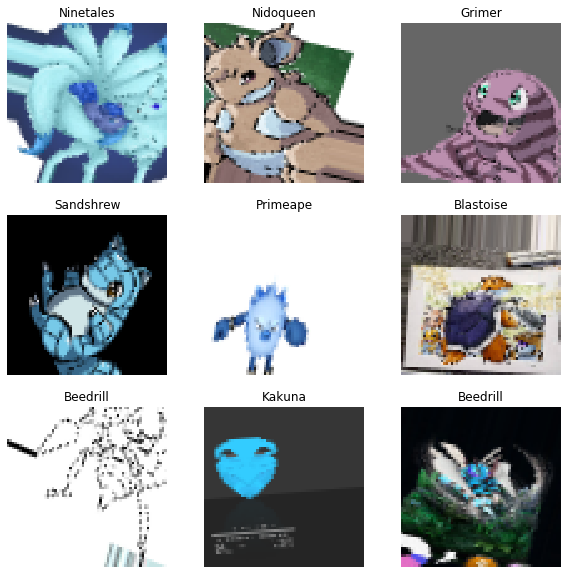

In [45]:
for X_batch, y_batch in data_aug.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    plt.figure(figsize=(10,10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.title(labels_dict[y_batch[i]])
        plt.imshow(X_batch[i].reshape(64, 64, 3))
        plt.axis('off')
    # show the plot
    # plt.savefig('figures/augmentated_pokemon_images.png')
    plt.show()
    break

## Converting a class vector (integers) to a binary class matrix before trainning CNN

In [46]:
num_classes = 151
y_train = np_utils.to_categorical(y_train, num_classes).astype('float32')
y_test = np_utils.to_categorical(y_test, num_classes).astype('float32')

    Why relu?
    Nonlinearities and preservation of dimension that help to improve the robustness of the network and control overfitting while other activate functions have a problem of vanishing gradients.

In [11]:
def create_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3,3), input_shape = (64, 64, 3), activation='relu'))
    cnn_model.add(BatchNormalization()) # Batch + MaxPool to make our model deeper(more parameters)
    cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    cnn_model.add(MaxPool2D(pool_size=(2,2))) # Reveals the maximum value from a collection of 4 elements (2x2) of the
                                              # incoming matrix to the output.
    cnn_model.add(Dropout(0.25)) # To construct independent activations for neurons in each intermediate weight layer.


    cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation = "relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(151, activation = "softmax"))
    return cnn_model

In [11]:
cnn_model = create_cnn_model()

In [12]:
cnn_model.compile(optimizer = rmsprop() , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
checkpoint = ModelCheckpoint('model/best_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

# Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, 
                                            verbose=1, min_lr = .0001)

In [14]:
train_generator = cnn_model.fit_generator(data_aug.flow(X_train,y_train, batch_size=32, shuffle=True),
                              epochs = 128, validation_data = (X_test,y_test),
                               steps_per_epoch=X_train.shape[0] // 32
                              , callbacks=[learning_rate_reduction, checkpoint])

Epoch 1/128
1050/1050 [==============================] - 71s - loss: 4.6610 - acc: 0.1023 - val_loss: 3.6112 - val_acc: 0.2251
Epoch 2/128
1050/1050 [==============================] - 69s - loss: 3.6809 - acc: 0.2142 - val_loss: 3.0395 - val_acc: 0.3153
Epoch 3/128
1050/1050 [==============================] - 69s - loss: 3.3034 - acc: 0.2725 - val_loss: 2.9046 - val_acc: 0.3512
Epoch 4/128
1050/1050 [==============================] - 69s - loss: 3.1160 - acc: 0.3133 - val_loss: 2.5152 - val_acc: 0.4281
Epoch 5/128
1050/1050 [==============================] - 69s - loss: 2.9861 - acc: 0.3397 - val_loss: 2.4579 - val_acc: 0.4450
Epoch 6/128
1050/1050 [==============================] - 69s - loss: 2.8946 - acc: 0.3598 - val_loss: 2.5861 - val_acc: 0.4157
Epoch 7/128
1050/1050 [==============================] - 69s - loss: 2.8113 - acc: 0.3774 - val_loss: 2.5718 - val_acc: 0.4311
Epoch 8/128
1050/1050 [==============================] - 69s - loss: 2.7985 - acc: 0.3791 - val_loss: 2.3455 - 

1050/1050 [==============================] - 69s - loss: 2.2453 - acc: 0.4957 - val_loss: 1.8718 - val_acc: 0.5885
Epoch 32/128
1050/1050 [==============================] - 69s - loss: 2.2238 - acc: 0.5024 - val_loss: 2.2221 - val_acc: 0.5537
Epoch 33/128
1050/1050 [==============================] - 69s - loss: 2.2351 - acc: 0.4990 - val_loss: 2.1946 - val_acc: 0.5423
Epoch 34/128
1050/1050 [==============================] - 69s - loss: 2.2232 - acc: 0.5063 - val_loss: 2.3851 - val_acc: 0.5556
Epoch 35/128
1050/1050 [==============================] - 69s - loss: 2.2082 - acc: 0.5053 - val_loss: 2.1700 - val_acc: 0.5645
Epoch 36/128
1050/1050 [==============================] - 69s - loss: 2.2142 - acc: 0.5053 - val_loss: 2.4581 - val_acc: 0.5497
Epoch 37/128
1049/1050 [============================>.] - ETA: 0s - loss: 2.1983 - acc: 0.5080
Epoch 00036: reducing learning rate to 0.00020000000949949026.
Epoch 00036: val_acc did not improve
1050/1050 [==============================] - 69s -

1050/1050 [==============================] - 69s - loss: 1.7650 - acc: 0.6116 - val_loss: 1.7897 - val_acc: 0.6682
Epoch 63/128
1050/1050 [==============================] - 69s - loss: 1.7499 - acc: 0.6135 - val_loss: 1.8229 - val_acc: 0.6641
Epoch 64/128
1050/1050 [==============================] - 69s - loss: 1.7609 - acc: 0.6103 - val_loss: 1.7400 - val_acc: 0.6695
Epoch 65/128
1050/1050 [==============================] - 69s - loss: 1.7560 - acc: 0.6110 - val_loss: 1.7726 - val_acc: 0.6690
Epoch 66/128
1049/1050 [============================>.] - ETA: 0s - loss: 1.7530 - acc: 0.6110
Epoch 00065: reducing learning rate to 1e-05.
Epoch 00065: val_acc did not improve
1050/1050 [==============================] - 69s - loss: 1.7532 - acc: 0.6111 - val_loss: 1.7822 - val_acc: 0.6689
Epoch 67/128
1050/1050 [==============================] - 69s - loss: 1.7440 - acc: 0.6163 - val_loss: 1.7799 - val_acc: 0.6669
Epoch 68/128
1050/1050 [==============================] - 69s - loss: 1.7393 - a

1050/1050 [==============================] - 69s - loss: 1.7234 - acc: 0.6178 - val_loss: 1.7704 - val_acc: 0.6698


In [14]:
def load_trained_model(weights_path):
    cnn_model = create_cnn_model()
    cnn_model.load_weights('model/best_model.hdf5')

In [47]:
from keras.models import load_model
cnn_model = load_model('model/best_model.hdf5')

In [48]:
pred_prob = cnn_model.predict(X_test)
pred_classes = np.argmax(pred_prob, axis=1)
acc = (np.argmax(y_test,axis=1) == pred_classes).mean()

print("Accuracy %.2f %%"% (acc*100))


Accuracy 72.92 %


Normalized confusion matrix
[[0.46875    0.         0.3125     ... 0.         0.         0.        ]
 [0.         0.92207792 0.01298701 ... 0.         0.         0.        ]
 [0.00729927 0.         0.89051095 ... 0.         0.         0.        ]
 ...
 [0.         0.02040816 0.02040816 ... 0.67346939 0.         0.        ]
 [0.         0.01694915 0.         ... 0.         0.79661017 0.        ]
 [0.         0.         0.         ... 0.         0.         0.58181818]]


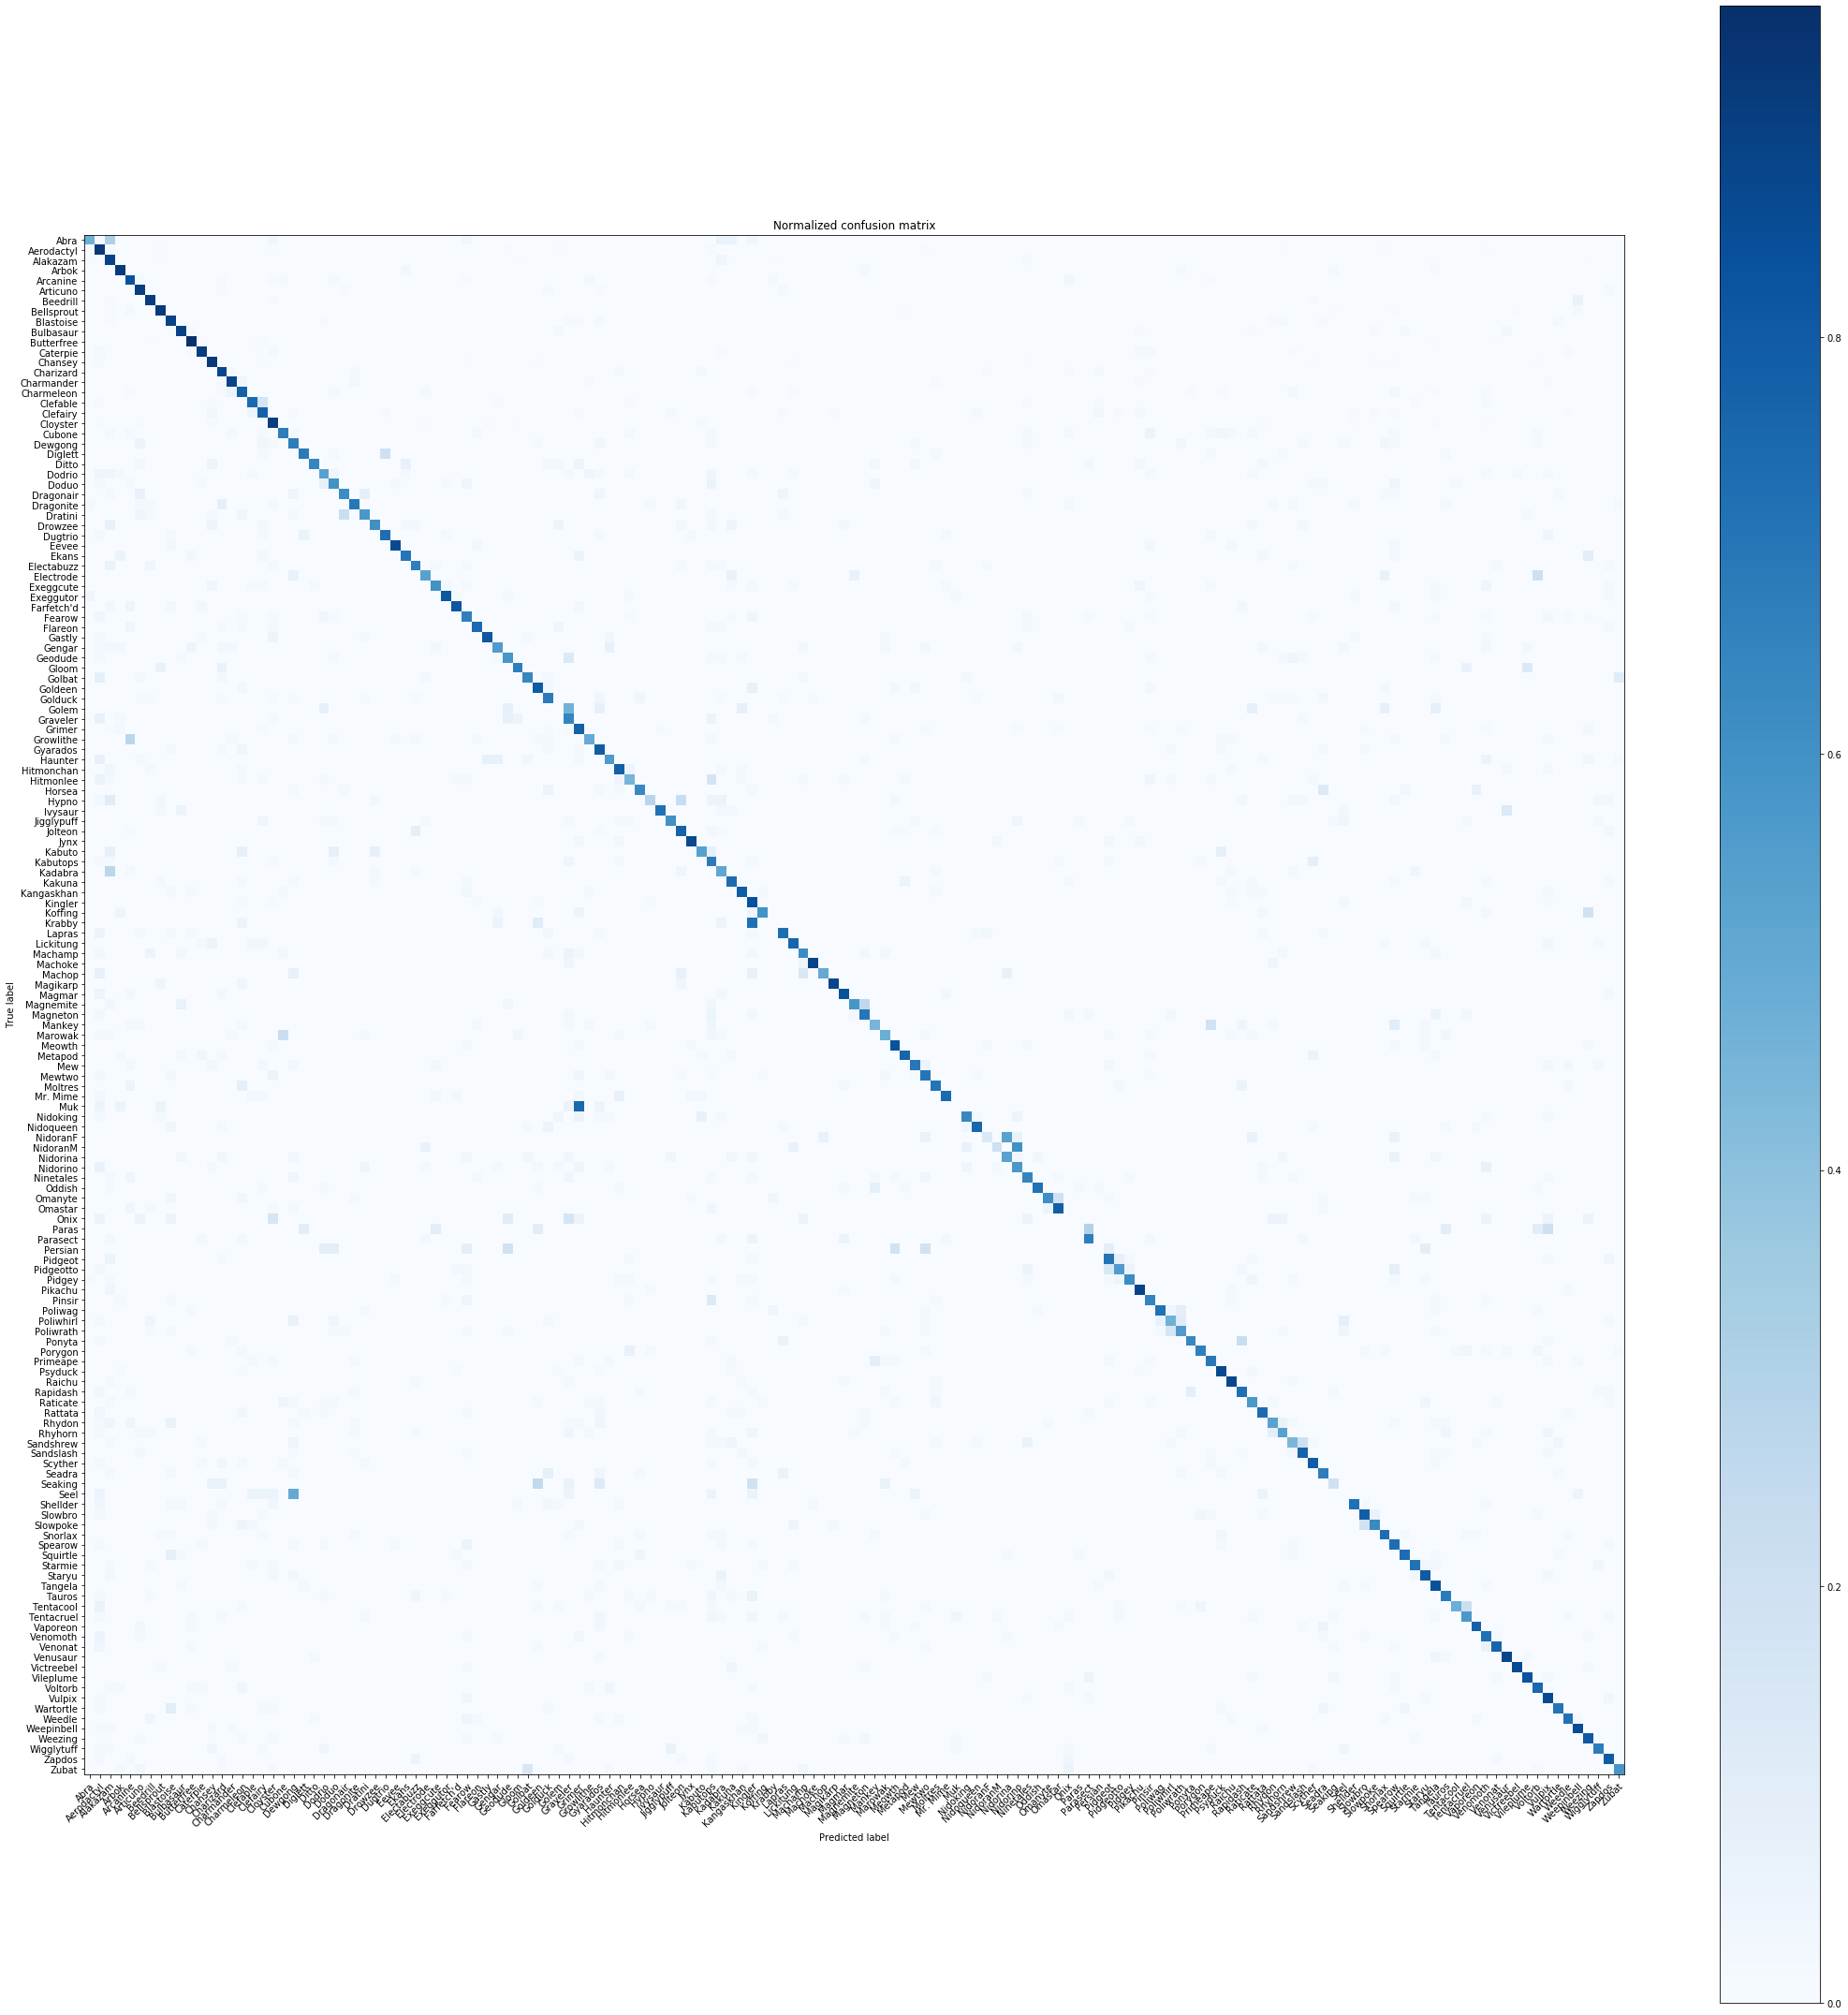

In [52]:
cnn_cm = confusion_matrix(np.argmax(y_test,axis=1),pred_classes)
plot_confusion_matrix(cnn_cm, labels_dict, normalize=True)

In [154]:
df_cnn_cm = pd.DataFrame(data=cnn_cm, index=labels_dict.values(), columns=labels_dict.values())
normalized_cnn_cm = df_cnn_cm.div(df_cnn_cm.sum(axis=1))
diag = np.diag(normalized_cnn_cm)
not_classified = np.where(diag.flatten() == 0)[0]
pokemon_not_classified = [labels_dict[n] for n in a]
print(pokemon_not_classified)

['Golem', 'Krabby', 'Muk', 'Onix', 'Paras', 'Persian']


These pokemons did not have enough image data compared to other pokemons. 
If we had more data of these pokemons, the model could have generated better prediction.

In [192]:
def get_false_negatives(df,pokemon):
    """
    input - df (confusion matrix dataframe)
    pokemon has to be in not classified list
    ['Golem', 'Krabby', 'Muk', 'Onix', 'Paras', 'Persian']
    Takes pokemon name and returns to its false negatives in order of rate
    
    """
    fn = df.loc[pokemon][df.loc[pokemon] > 0].sort_values(ascending=False)
    return(fn.index.values.tolist())

for pokemon in pokemon_not_classified:
    print(pokemon, get_false_negatives(normalized_cnn_cm,pokemon))
    print('--------------------------------------------------------------------------')

Golem ['Graveler', 'Geodude', 'Raticate', 'Kangaskhan', 'Weedle', 'Dodrio', 'Primeape', 'Tangela', 'Fearow', 'Cloyster']
--------------------------------------------------------------------------
Krabby ['Kingler', 'Seel', 'Snorlax', 'Jolteon', 'Charmeleon']
--------------------------------------------------------------------------
Muk ['Grimer', 'Ekans', 'Cloyster']
--------------------------------------------------------------------------
Onix ['Graveler', 'Geodude', 'Rhydon', 'Ninetales', 'Gastly', 'Sandslash', 'Blastoise', 'Cloyster']
--------------------------------------------------------------------------
Paras ['Parasect', 'Onix', 'Kingler', 'Goldeen', 'Weedle', 'Vulpix', 'Diglett', 'Voltorb', 'Aerodactyl', 'Beedrill', 'Cloyster']
--------------------------------------------------------------------------
Persian ['Meowth', 'Geodude', 'Mankey', 'Rhyhorn', 'Doduo', 'Ninetales', 'Kangaskhan', 'Growlithe', 'Arcanine']
----------------------------------------------------------------

    Furthermore, we see our neural network cannot distinguish thoroughly when it gets similar pokemon.
    In this project, similar pokemons can be thought as pokemons with evolutions.
    For example, Muk is evoutionalized version of Grimer, Kingler ---> Krabby and lastly Meowth ---> Persian.
    Onix and Graveler are rock pokemons and have similar features, so our false negative pokemons were rock pokemons.

In [207]:
report = classification_report(y_test,pred,target_names=list(labels_dict.values()),output_dict = True)
classification_report_df = pd.DataFrame(report).T
classification_report_df.head()

f1-score  precision    recall  support
Abra        0.700000   0.875000  0.583333     36.0
Aerodactyl  0.767857   0.668394  0.902098    143.0
Alakazam    0.734807   0.633333  0.875000    152.0
Arbok       0.895397   0.877049  0.914530    117.0
Arcanine    0.729927   0.657895  0.819672    122.0

    How to improve precision and recall??

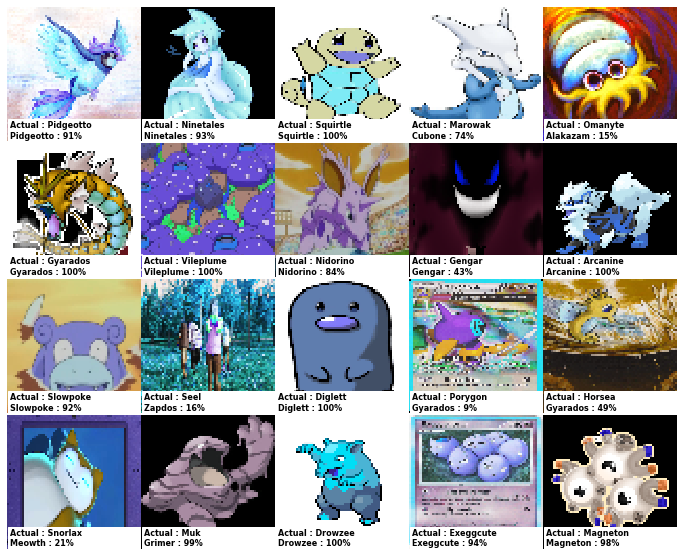

In [228]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y_test) for key in rand_pokemon_keys]
display_sample_pokemons(samples_indices, X_test, y_test,pred_classes,pred_prob)

## Try with another test image files

In [78]:
def collecting_test(dirs):
    """
    dirs - directory which contains png files
    """
    test_image_data = []
    for img_path in sorted(dirs):
        img_path = str(img_path) 
        img = cv2.imread(img_path)
        img = cv2.resize(img,(64,64)) # Resize an image to 64 pixels by 64 pixels
        img_array = image.img_to_array(img) # Convert an image to an array
        test_image_data.append(img_array/255.0)
    
    test_image_data = np.squeeze(test_image_data)
    
    return(test_image_data)


In [ ]:
# p2 = Path("./data/pokemon_test")
# dirs2 = p2.glob("*.png")
# test_image_data = collecting_test(dirs2)

In [66]:
# pickle.dump(test_image_data, open('data/test_image.p', 'wb'))
test_image_data = pickle.load(open('data/test_image.p', 'rb'))

In [121]:
test_pred_prob = cnn_model.predict(test_image_data)
test_pred_classses = np.argmax(test_pred_prob, axis=1)

In [57]:
def plot_test_image(test_image, pred_classes, pred_prob,labels_dict):
    """ input: test_image (a ndarray of containing pixels of an image)
               pred_classes (a list of predicted classes of key)
               labels_dict (a dictionary containg key: pokemon )
               
        returns showing test images with labeled predicted name
        
    """
    n = 0
    row = 1
    ncols = 5
    for i in range(0,len(test_image),5):
        fig, ax = plt.subplots(row,ncols,figsize= (12,10))
        plt.subplots_adjust(wspace=0, hspace=0)
        for col in range(ncols):
            if (i >= len(test_image)):
                remove = ncols - (len(test_image) % 5)
                for rem in range(remove+1):
                    ax[rem].set_axis_off()
                break
            percent = (pred_prob[i][pred_classes[i]] * 100).astype(int).astype(str)
            ax[col].set_title(labels_dict[pred_classes[i]] + ":" + percent, loc='left', fontsize=10)
            ax[col].imshow(test_image[i])
            ax[col].axis('off')
            i += 1


IndexError: index 171 is out of bounds for axis 0 with size 171

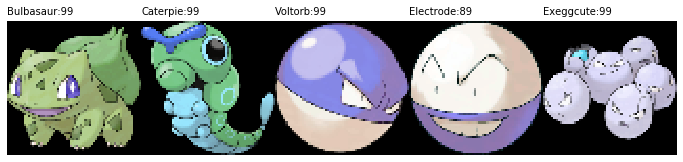

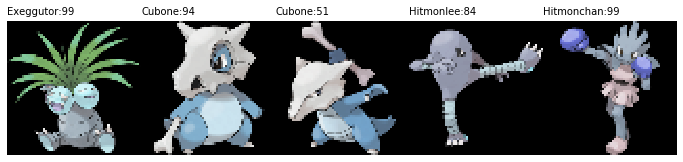

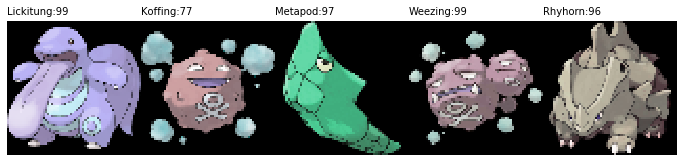

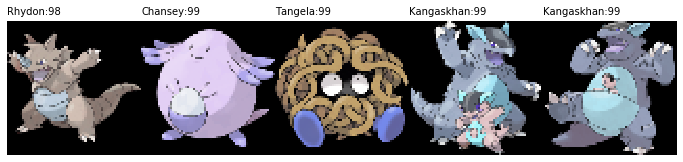

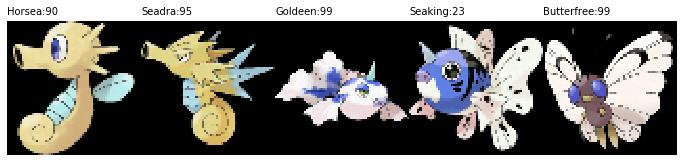

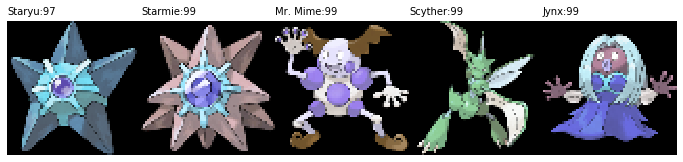

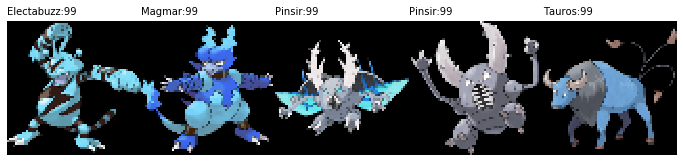

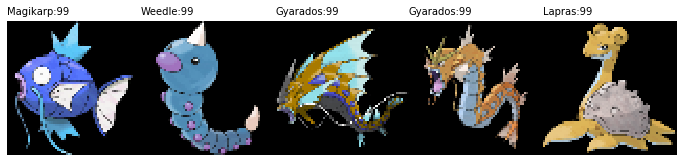

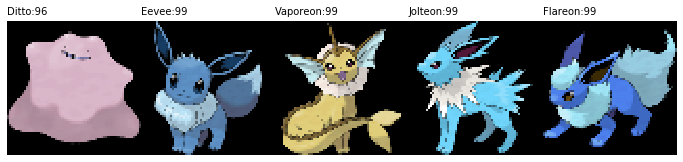

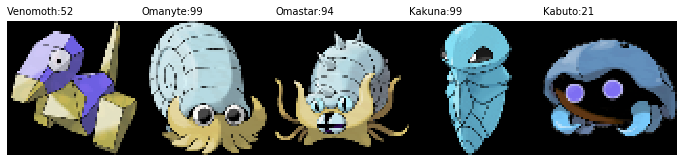

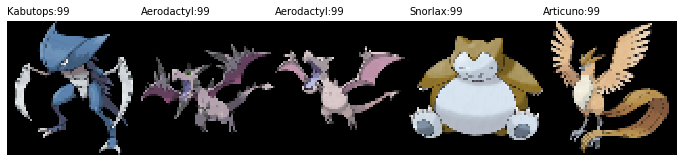

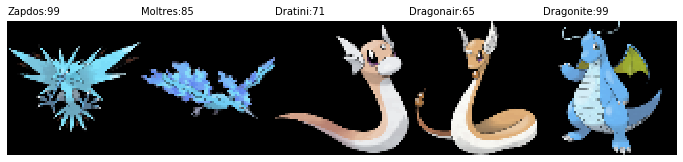

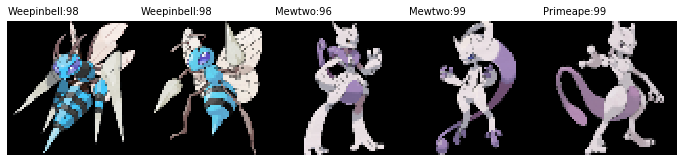

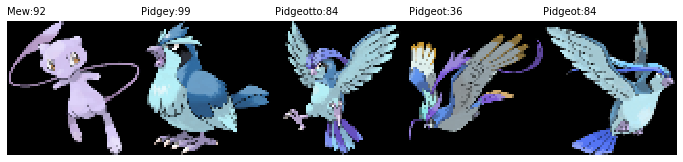

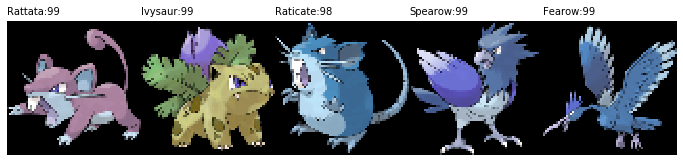

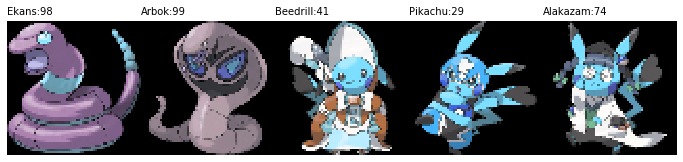

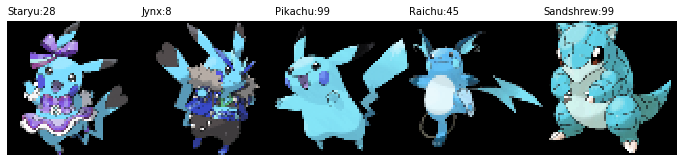

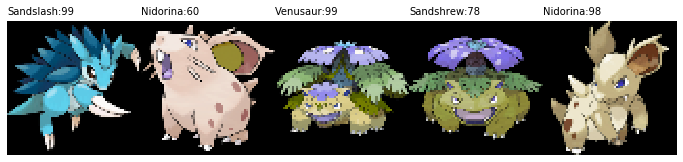

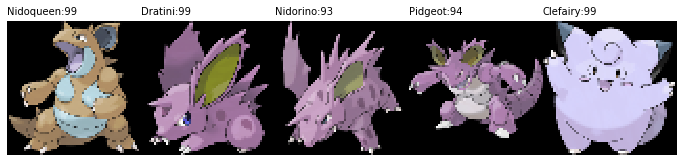

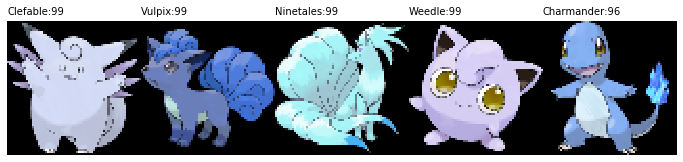

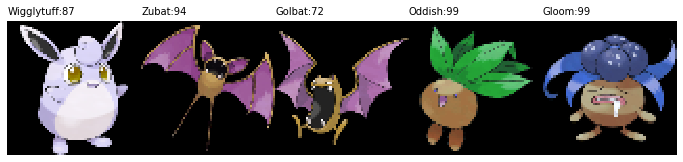

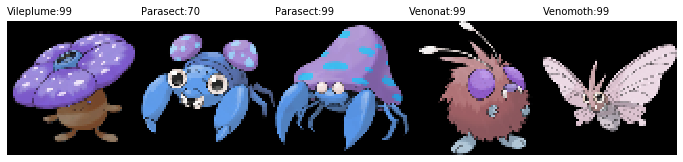

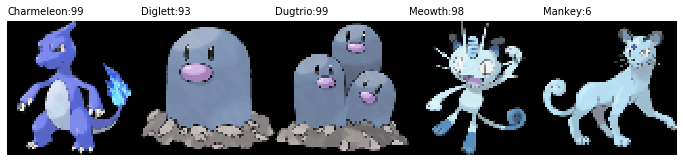

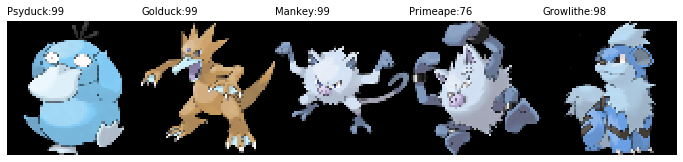

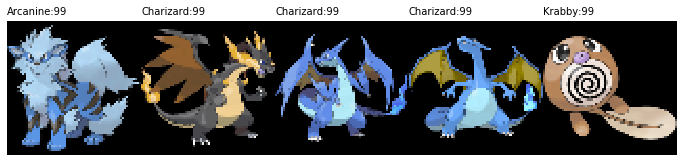

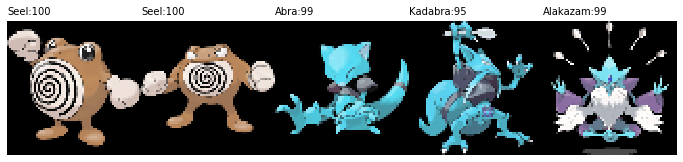

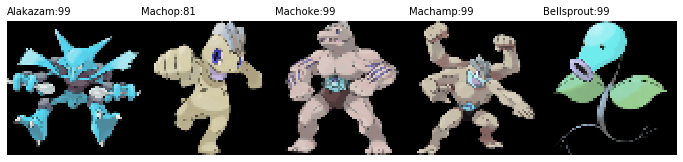

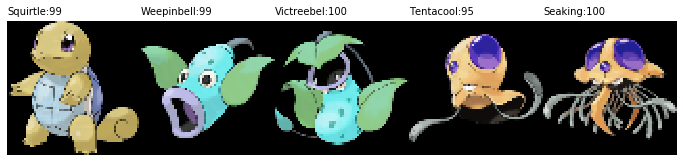

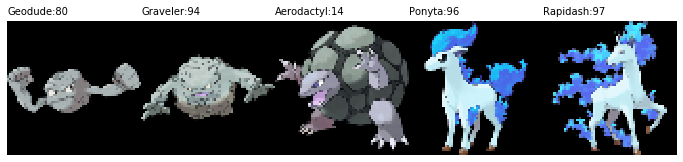

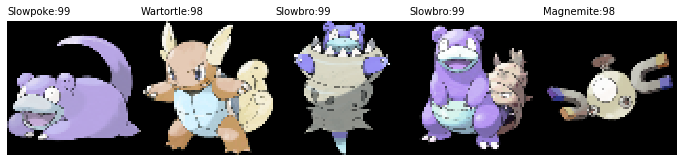

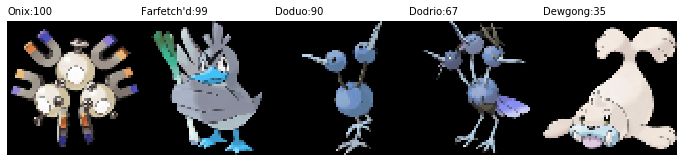

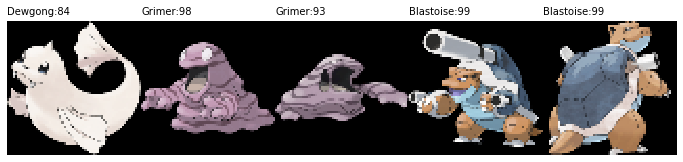

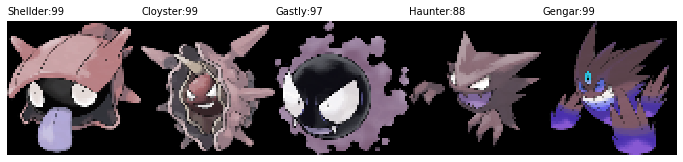

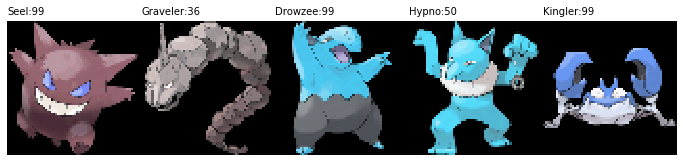

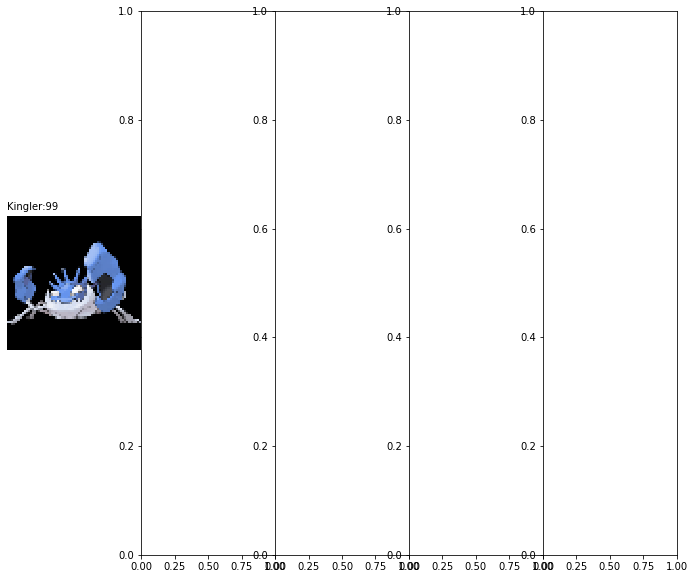

In [119]:
plot_test_image(test_image_data, test_pred_classses, test_pred_prob,labels_dict)

## Video DEMO


In [21]:
def load_icons_pokemons(filenames):
    dict_io = {}
    for file_path in filenames:
        file_path = str(file_path)
        pokemon_icon = cv2.imread(file_path)
        pokemon_icon = cv2.resize(pokemon_icon,(48,48),interpolation=cv2.INTER_LANCZOS4)
        pokemon = file_path.split('/')[-1].split('.png')[0].capitalize()
        dict_io[pokemon] = pokemon_icon
    return dict_io

p = Path("./data/pokemon_icons")
filenames = sorted(p.glob("*.png"))
icons = load_icons_pokemons(filenames)

In [22]:
# video_capture = cv2.VideoCapture("./data/video/pokemon_intro.mp4")

# fourcc = cv2.VideoWriter_fourcc(*'MP4V')
# fps = int(video_capture.get(cv2.CAP_PROP_FPS))
# height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
# width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
# out = cv2.VideoWriter('./data/video/output.mp4', fourcc, 20, (width,height))

In [ ]:
# while video_capture.isOpened():
#     # Capture frame-by-frame
#     ret, frame = video_capture.read()
#     frame_for_pred = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
#     frame_reshaped = cv2.resize(frame_for_pred,(64,64),interpolation=cv2.INTER_LANCZOS4)/255.0
#     frame_reshaped_array = image.img_to_array(frame_reshaped)
#     Y_pred = cnn_model.predict(np.array([frame_reshaped_array]))
    
#     index_sorted = np.argsort(Y_pred,axis= 1)[0]
    
#     top1_pred = Y_pred[0][index_sorted][-1]
#     top2_pred = Y_pred[0][index_sorted][-2]
#     top3_pred = Y_pred[0][index_sorted][-3]
    
#     # I only display confident predictions (>=70%) 
#     if top1_pred > .7:
#         pokemon_top1 = labels_dict[index_sorted[-1]]
#         pokemon_top2 = labels_dict[index_sorted[-2]]
#         pokemon_top3 = labels_dict[index_sorted[-3]]

#         Text1 = "%s : %.2f%%"%(pokemon_top1.split('_')[0],top1_pred*100)
#         Text2 = "%s : %.2f%%"%(pokemon_top2.split('_')[0],top2_pred*100)
#         Text3 = "%s : %.2f%%"%(pokemon_top3.split('_')[0],top3_pred*100)

#         frame[2:50,2:50] = icons[pokemon_top1]
#         cv2.putText(frame,Text1,(2,65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

#         frame[80:128,2:50] = icons[pokemon_top2]
#         cv2.putText(frame,Text2,(2,143), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

#         frame[158:206,2:50] = icons[pokemon_top3]
#         cv2.putText(frame,Text3,(2,221), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

#         # Display the resulting frame
#         cv2.imshow('Video', frame)

#         out.write(frame)

#         cv2.waitKey(0)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
    
# # When everything is done, release the capture
# video_capture.release()
# out.release()
# cv2.destroyAllWindows()


Sliding Windows(you can set up a particular size/ start with larger number) and apply bounding boxes


## RCNN
    Even though my model well classified pokemon based on its images, it could not classify pokemons in a video.
    Now I want to try Object Detection on Pokemon by appling sliding window and bounding boxes. To see if the problem was sliding window, I manually extracted frames from the video and predict it with my model

In [79]:
# p3 = Path('./data/pok_in_videos')
# dirs3 =p3.glob("*.png")
# video_img = collecting_test(dirs3)
# pickle.dump(video_img, open('data/video_img.p', 'wb'))

In [54]:
video_img = pickle.load(open('data/video_img.p', 'rb'))

In [55]:
video_pred_prob = cnn_model.predict(video_img)
video_pred_classses = np.argmax(video_pred_prob, axis=1)

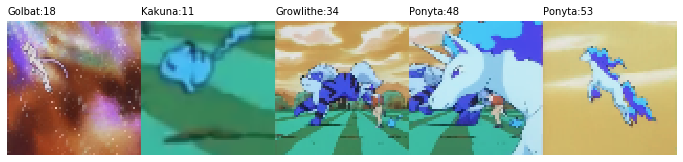

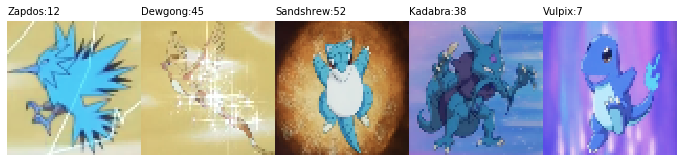

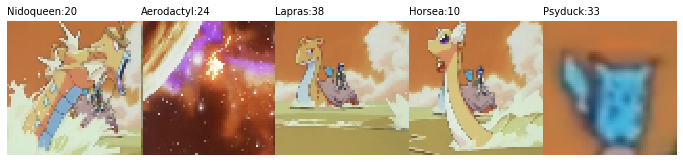

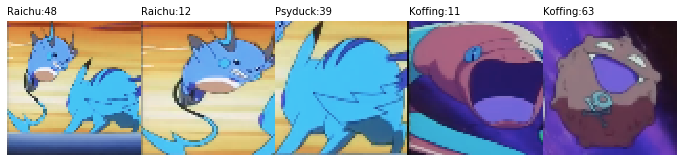

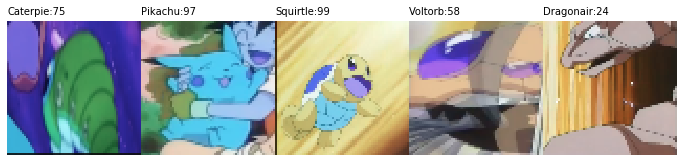

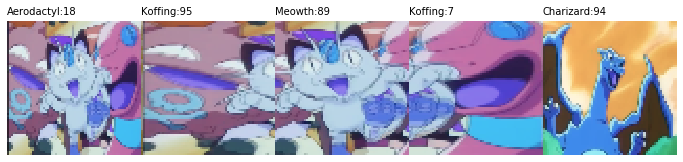

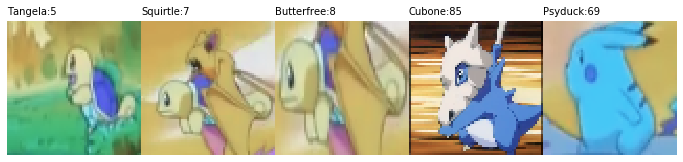

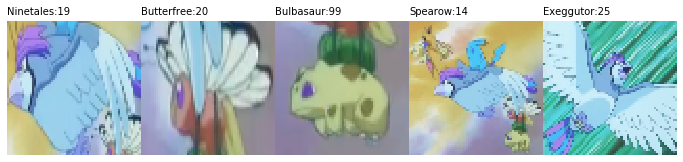

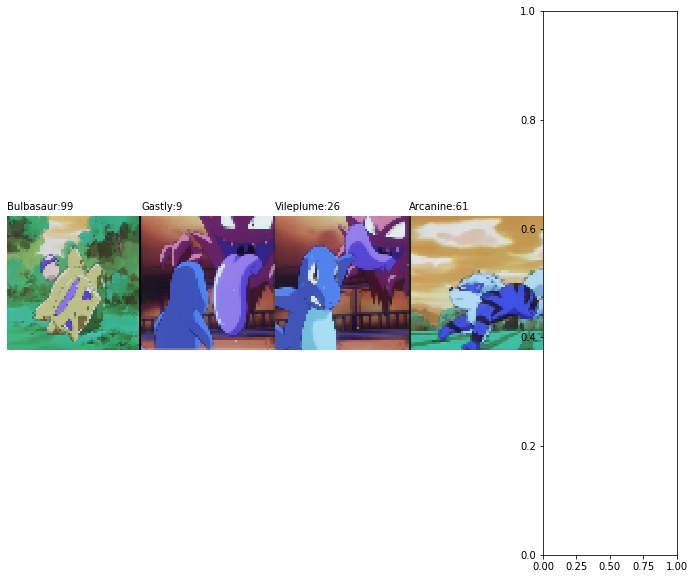

In [58]:
plot_test_image(video_img, video_pred_classses, video_pred_prob,labels_dict)

# Lime 

In [ ]:
from skimage.segmentation import mark_boundaries

In [119]:
def display_lime_explanataion(img,model):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=None, num_samples=1000)
    fig, ax = plt.subplots(1,2,figsize= (12,10))
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    ax[0].set_xlabel('most positive towards the class with the rest of the image hidden')
    ax[1].set_xlabel('pros (green) and cons (red)')
    ax[0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax[1].imshow(mark_boundaries(temp2 / 2 + 0.5, mask2))
    

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


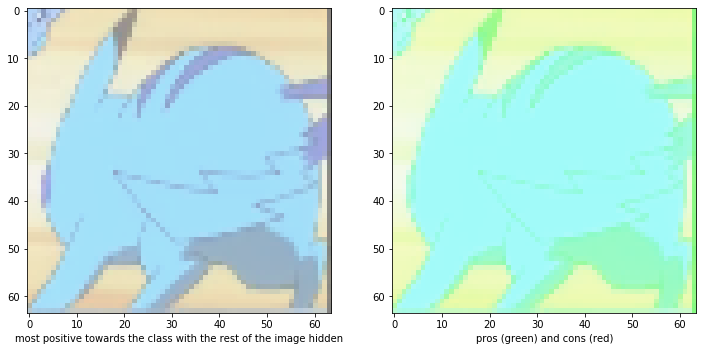

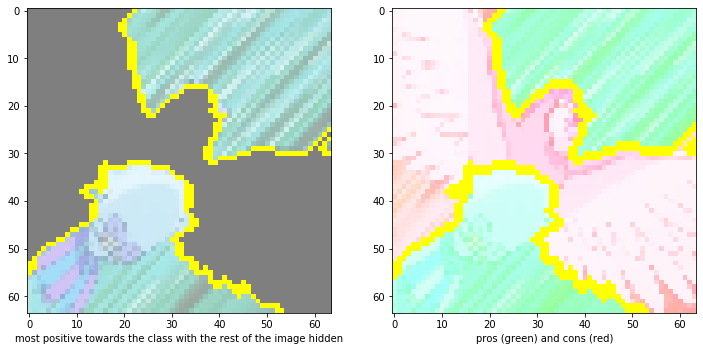

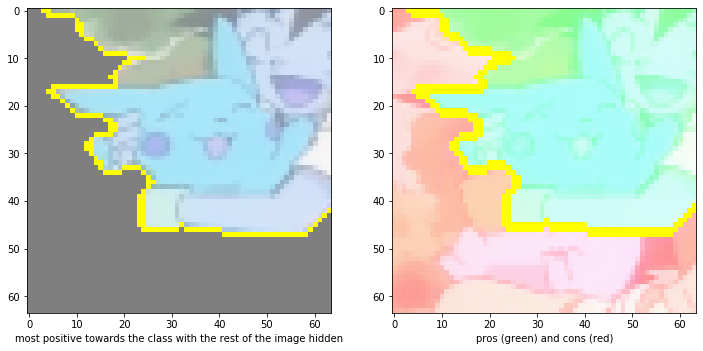

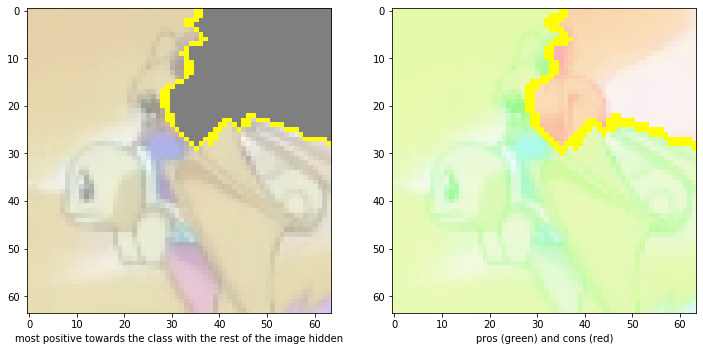

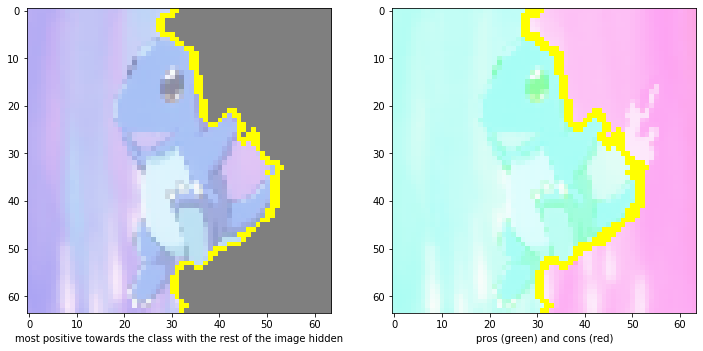

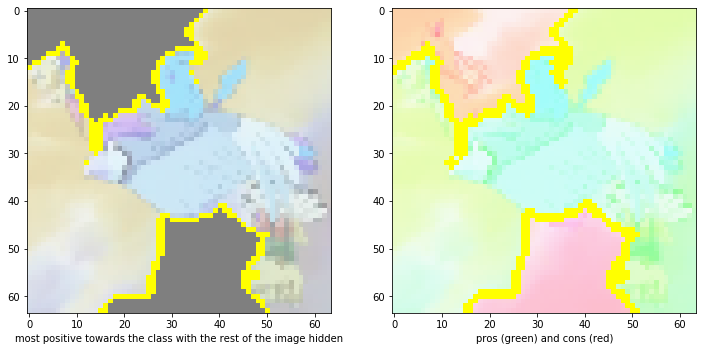

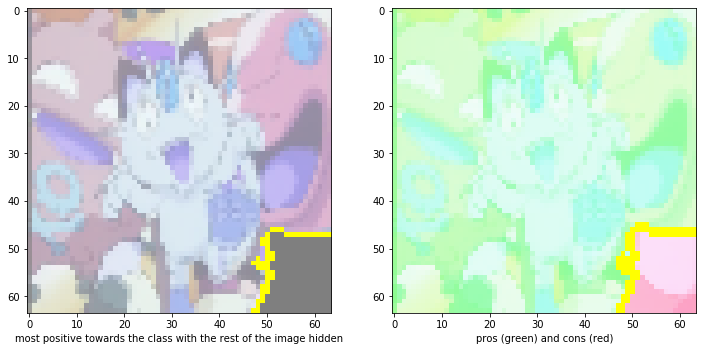

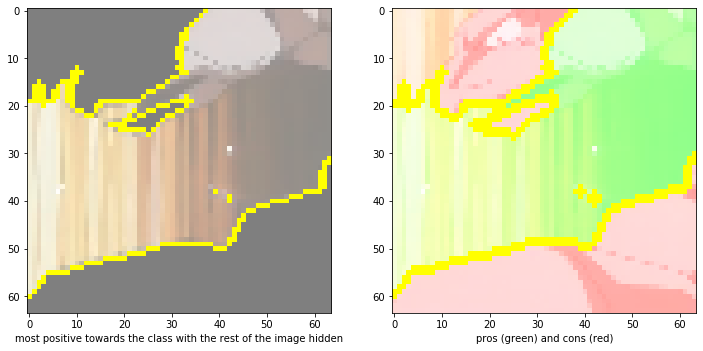

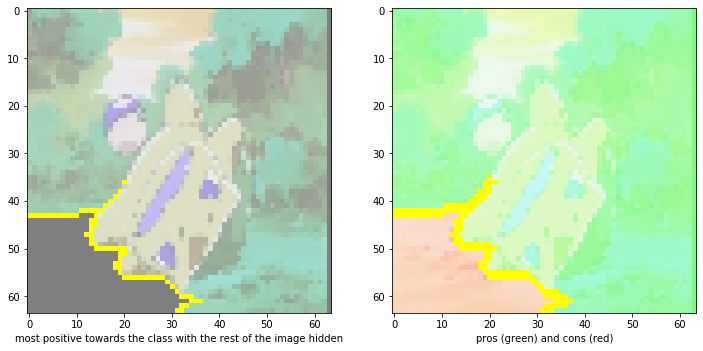

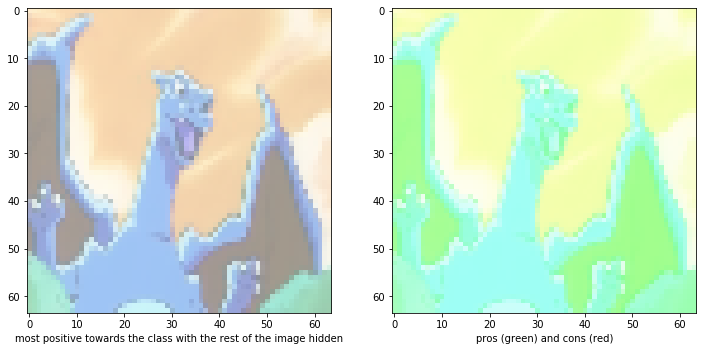

In [120]:
random_pok_image = random.sample(range(0,len(video_img)),10)
for img in random_pok_image:
    display_lime_explanataion(video_img[img],cnn_model)
    

    Lime uses a superpixel, which is a group of pixels that share common characteristics (like pixel intensity), to see how pixel contributes the model. If the superpixel effects the model positively, it will return to green area as 2nd column of the plot above. First column of the plot represents color area as superpixels contributed positvely to the model.